In [56]:
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import ImageFilter
from torchvision.transforms.transforms import RandomAffine, Resize
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

In [2]:
data_path = "D:\\APS360 Data\\Subset\\" # Replace with wherever you store your subset

In [3]:
os.listdir(data_path)

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'space',
 'del',
 'call',
 'ok']

In [4]:
def show_image(path):
    img = mpimg.imread(path)
    plt.imshow(img)
    return img

# Data Augmentation
## Padding

In [5]:
def resize_and_pad_image(image, output_size=(256, 256)):
    h, w, _ = image.shape
    pad_width = abs(h-w) // 2
    
    if h > w:
        image = cv2.copyMakeBorder(image, 0, 0, pad_width, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    elif h < w:
        image = cv2.copyMakeBorder(image, pad_width, pad_width, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    image = cv2.resize(image, output_size)
    return image

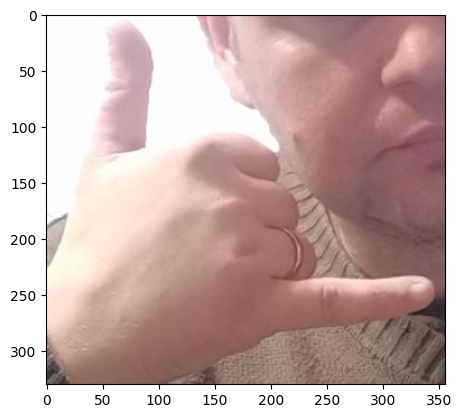

In [6]:
img = show_image(data_path+"call\\"+os.listdir(data_path+"call")[106])

In [7]:
img.shape

(330, 356, 3)

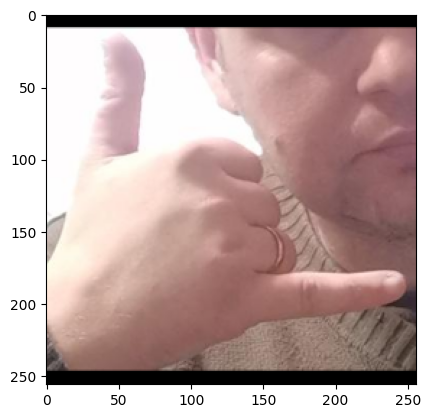

In [8]:
padded_img = resize_and_pad_image(img)
plt.imshow(padded_img)

In [41]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        instances = []
        for target_class in sorted(self.class_to_idx.keys()):
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    instances.append(item)
        return instances

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
        if self.transform:
            image = self.transform(image)
        return image, target

    @staticmethod
    def resize_and_pad_image(image, output_size=(256, 256)):
        h, w, _ = image.shape
        pad_width = abs(h-w) // 2
        
        if h > w:
            image = cv2.copyMakeBorder(image, 0, 0, pad_width, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        elif h < w:
            image = cv2.copyMakeBorder(image, pad_width, pad_width, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        image = cv2.resize(image, output_size)

        return Image.fromarray(image)

In [42]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Lambda(lambda x: CustomImageDataset.resize_and_pad_image(np.array(x))),  # Your custom resize and pad
    # Data Augmentation
    transforms.RandomApply([
        transforms.RandomAffine(degrees=15, scale=(0.85, 1.15)),  # Random rotation and scaling
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Random blurring
    ], p=0.15),  # Apply the above transformations with 30% probability
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

In [44]:
# Seeding to ensure reproducibility!
random.seed(42)
torch.manual_seed(42)

In [45]:
# class SeededRandomApplyOne(torch.nn.Module):
#     def __init__(self, transforms, p=0.3, seed=None):
#         super(SeededRandomApplyOne, self).__init__()
#         self.transforms = transforms
#         self.p = p
#         self.seed = seed

#     def forward(self, img):
#         if self.seed is not None:
#             # Seed the random number generator for reproducibility
#             random.seed(self.seed)
#             torch.manual_seed(self.seed)
        
#         if random.random() < self.p:
#             # Randomly pick one transformation to apply
#             t = random.choice(self.transforms)
#             img = t(img)
#         return img

#     def __repr__(self):
#         format_string = self.__class__.__name__ + '('
#         format_string += 'p={0}'.format(self.p)
#         if self.seed is not None:
#             format_string += ', seed={0}'.format(self.seed)
#         format_string += '\n'
#         for t in self.transforms:
#             format_string += '    {0}\n'.format(t)
#         format_string += ')'
#         return format_string

In [46]:
# custom_transforms = [
#     transforms.RandomAffine(degrees=15, scale=(0.85, 1.15)),
#     transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
# ]

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     SeededRandomApplyOne(custom_transforms, p=0.15, seed=42), # This seed
#     # ensures that the results are the same everytime!
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

In [47]:
# Load your dataset
dataset = CustomImageDataset(root_dir=data_path, transform=transform)

In [48]:
len(dataset)

10500

In [49]:
dataloader = DataLoader(dataset, shuffle=False)

In [50]:
len(dataloader)

10500

In [51]:
# Placeholder for data and labels
all_data = []
all_labels = []

for data, labels in dataloader:
    all_data.append(data)
    all_labels.append(labels)

10500


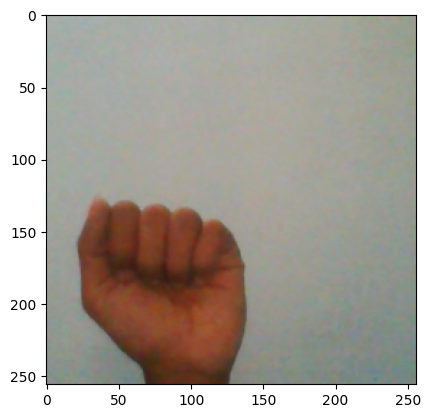

In [53]:
# Run this after!
print(len(all_data))
image = all_data[1].numpy()

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
mean = torch.tensor(mean).view(1, 3, 1, 1)
std = torch.tensor(std).view(1, 3, 1, 1)

image = std * image + mean
image = torch.clamp(image, 0, 1)
image = torch.squeeze(image)
image = image.permute(1, 2, 0)
image = image.cpu().numpy()
plt.imshow(image)

In [54]:
import torch
all_data_tensor = torch.cat(all_data, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

In [55]:
torch.save(all_data_tensor, 'data_tensor.pth')
torch.save(all_labels_tensor, 'labels_tensor.pth')

## Train val split

In [57]:
torch.manual_seed(42)
total_size = len(dataset)
train_size = int(total_size * 0.7)  # 70% for training
val_size = int(total_size * 0.2)    # 20% for validation
test_size = total_size - train_size - val_size  # Remaining 10% for testing

In [58]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [59]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)